Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

C:\Users\USER\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Get data

In [2]:
filename = '110524.csv'

dfin = pd.read_csv(filename)
dfin = pd.get_dummies(dfin, columns=['gender'])

#drop the empty column at the beginning
df = dfin.drop('Unnamed: 0',axis = 1)
#encode gender as a 0/1


#remove categorical columns except the column of interest and  one gender
droplist= ['file_name', 'language', 'gender_M'] #since gender M is 100% linearly dependent of gender F 
df = df.drop(droplist, axis=1)

#separate out the known labels from the predictors
labcol = ['emotion']
labels = df[labcol]
features = df.drop(labcol, axis=1)

print(labels)
print(features)


     emotion
0        ANG
1        SAD
2        ANG
3        SAD
4        ANG
...      ...
2528     HAP
2529     HAP
2530     SAD
2531     HAP
2532     HAP

[2533 rows x 1 columns]
      sample_rate  bit_depth  duration  syllabic_rate  zcr_mean   zcr_std  \
0           22050         16  1.439637       0.694619  0.124574  0.139607   
1           22050         16  2.321995       0.430664  0.148597  0.217951   
2           22050         16  3.041814       0.328751  0.204938  0.114941   
3           22050         16  2.391655       0.418120  0.105257  0.164129   
4           22050         16  2.484535       0.402490  0.188427  0.075686   
...           ...        ...       ...            ...       ...       ...   
2528        22050         16  2.113016       0.473257  0.147180  0.192641   
2529        22050         16  2.554195       0.391513  0.069785  0.078659   
2530        22050         16  2.254331       0.443591  0.080342  0.133835   
2531        22050         16  1.486077       0.67

features, true_labels = make_blobs(
    n_samples=200,
    centers=3,
    cluster_std=2.75,
    random_state=42
)
print(features[:5])
print(true_labels[:5])

## Center and Scale

In [3]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features[:5]

array([[ 0.        , -0.4083423 , -0.88515553, ...,  2.56436192,
         6.27434746, -1.17215427],
       [ 0.        , -0.4083423 , -0.21070477, ...,  0.39388066,
         0.01900058,  0.85313002],
       [ 0.        , -0.4083423 ,  0.33950506, ..., -2.4195102 ,
        -1.0571579 , -1.17215427],
       [ 0.        , -0.4083423 , -0.15745866, ..., -1.16686043,
        -0.71588184, -1.17215427],
       [ 0.        , -0.4083423 , -0.08646384, ...,  0.35876643,
         0.12459563, -1.17215427]])

# K-means clustering

In [4]:
#make modeling
kmeans = KMeans(
    init="random", #initialization technique
    n_clusters=3, # num of clusters
    n_init=10, #of starts to run
    max_iter=300, # num of iterations for each start
)

#make model for our input
kmeans.fit(scaled_features)

#results of the clustering:
print("The lowest SSE value", kmeans.inertia_)
print("Final locations of the centroid", kmeans.cluster_centers_)
print("The number of iterations required to converge", kmeans.n_iter_)
#some cluster results:
kmeans.labels_[:5]

The lowest SSE value 1391508.7520829153
Final locations of the centroid [[ 0.          0.39089353  0.45503217 ... -0.20206807 -0.17027065
   0.13869407]
 [ 0.         -0.4083423  -0.45858506 ...  0.1836015   0.21439361
  -0.63468438]
 [ 0.         -0.39463838 -0.49270836 ...  0.2586474   0.09929503
   0.83370283]]
The number of iterations required to converge 13


array([1, 1, 0, 1, 0])

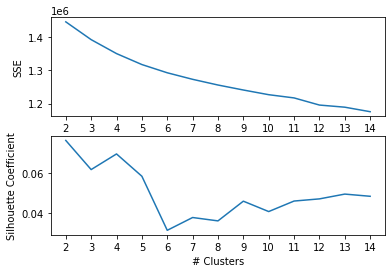

In [5]:
#Try Elbow Method
kmeans_kwargs = {
    "init": "random",
    "n_init": 40,
    "max_iter": 300
}

# A list holds the SSE values for each k
sse = []
# A list holds the silhouette coefficients for each k
silhouette_coeffs = []
tryks = 15 #max number of clusters to try

for k in range(2, tryks):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coeffs.append(score)
    
#Make Elbow plot, want turning point
plt.subplot(2, 1, 1)
plt.plot(range(2, tryks), sse)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("SSE")

#Make silhouette plot, want max score
plt.subplot(2, 1, 2)
plt.plot(range(2, tryks), silhouette_coeffs)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [6]:
#find elbow mathematically:
kl = KneeLocator(
    range(2, tryks), sse, curve="convex", direction="decreasing"
)

kelbow = kl.elbow
print(kelbow)

6


In [7]:
#find max cluster number mathematically
maxsc = max(silhouette_coeffs)
katmaxsc = silhouette_coeffs.index(maxsc)+2
print(katmaxsc)

2


Do these clusters correspond with any emotions?

In [8]:
#Run with k from elbow method:
kmeanselbow = KMeans(n_clusters=kelbow, **kmeans_kwargs)
elbowclusters = kmeanselbow.fit_predict(scaled_features)
#Run with k from silhouette coeffs method:
kmeanssil = KMeans(n_clusters=katmaxsc, **kmeans_kwargs)
silclusters = kmeanssil.fit_predict(scaled_features)

labels['elbow'] = elbowclusters
labels['silhouette'] = silclusters
print(labels)

     emotion  elbow  silhouette
0        ANG      0           1
1        SAD      2           1
2        ANG      4           0
3        SAD      2           1
4        ANG      4           0
...      ...    ...         ...
2528     HAP      3           1
2529     HAP      5           0
2530     SAD      2           1
2531     HAP      5           0
2532     HAP      3           1

[2533 rows x 3 columns]


<ipython-input-8-6e76646e0493>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['elbow'] = elbowclusters
<ipython-input-8-6e76646e0493>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['silhouette'] = silclusters


In [9]:
#now compare
grouped0 = labels.groupby(['emotion', 'elbow']).size().reset_index(name='count')
grouped1 = labels.groupby(['emotion', 'silhouette']).size().reset_index(name='count')

print(grouped1)

  emotion  silhouette  count
0     ANG           0    481
1     ANG           1    406
2     HAP           0    414
3     HAP           1    418
4     SAD           0    402
5     SAD           1    412


With 2 groups, there is no differentiation between the emotions

In [10]:
print(grouped0)

   emotion  elbow  count
0      ANG      0    212
1      ANG      1    199
2      ANG      2      2
3      ANG      4    320
4      ANG      5    154
5      HAP      0     10
6      HAP      1      6
7      HAP      2    202
8      HAP      3    196
9      HAP      4    213
10     HAP      5    205
11     SAD      0      3
12     SAD      1      7
13     SAD      2    397
14     SAD      3      1
15     SAD      4     61
16     SAD      5    345


With more groups, there is some differentiation. Let's get a better look.

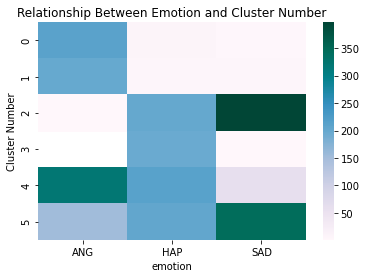

In [11]:
grouped0['count'] = grouped0['count'].astype(int) #avoid float error
grouped0['elbow'] = grouped0['elbow'].astype(str) #avoid float error
heatmap_data = grouped0.pivot('elbow', 'emotion', 'count')
hm = sns.heatmap(heatmap_data, cmap="PuBuGn")
plt.title('Relationship Between Emotion and Cluster Number')
hm.set_ylabel('Cluster Number')
plt.show()